<a href="https://colab.research.google.com/github/vivianemattos/mvp-vmm-machineLearning-analytics/nomedonotebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# MVP: *Machine Learning & Analytics*

**Nome:** Viviane Mendes Matos

**Matrícula:** 4052025000007

**Dataset:** [Disney+ Dataset from Kaggle](https://raw.githubusercontent.com/vivianemattos/mvp-vmm-analise-dados-boas-praticas/refs/heads/main/disney_plus_titles_w43.csv)

---



## 1. Escopo, objetivo e definição do problema

O Disney+ é uma das plataformas de streaming mais populares disponíveis atualmente e como referência em 2021 contava com cerca de 116 milhões de assinantes em todo o mundo. O conjunto de dados Filmes Disney+ é multivariado e contém uma lista de 1450 filmes e shows detalhando elenco, diretores, classificações, ano de lançamento, duração, etc.

O objetivo principal deste projeto é construir uma solução de machine learning com aprendizado não supervisionado e baseada em clusterização hierárquica aplicada a dados tabulares para viabilizar recomendações de títulos do catálogo Disney+.

Esta opção foi escolhida porque Clusters coerentes em atributos editoriais (ano/classificação) fornecem um ponto de partida **simples, interpretável e barato** para recomendação quando não há sinais históricos de consumo.

Este tipo de dinâmica é comumente aplicada para sugerir títulos similares aos que são consumidos pelos assinantes e assim aumentar o engajamento. Com uma extensa base de conteúdo, acaba sendo muito útil aos assinantes receber sugestões de novos títulos baseados no que foi assistido e para o streaming é uma forma de oferecer um conteúdo mais direcionado aos interesses do assinante, possibilitando assim o aumento da quantidade de conteúdos assistidos mais rapidamente. Para a plataforma, além do engajamento, facilita a segmentação de público sendo também especialmente útil para fornecer insights sobre curadoria e para futuras decisões estratégicas de produção.




## 2. Reprodutibilidade e ambiente


Definimos dependências, fixamos seeds e criamos utilitários para reprodutibilidade. Há um bloco para execução de instalações adicionais sempre que necessário.

### 2.1 Bibliotecas

In [33]:
#Bibliotecas

import os, sys, time, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from statistics import mode
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.exceptions import ConvergenceWarning
import warnings

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster

import joblib
import psutil
from dataclasses import dataclass

from typing import Tuple, Dict


#Utilidades

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def set_global_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

def now():
    return time.strftime("%Y-%m-%d %H:%M:%S")

def log(msg):
    print(f"[{now()}] {msg}")

@dataclass
class ClusterConfig:
    linkage_method: str = "ward"      # 'ward', 'complete', 'average'
    metric: str = "euclidean"         # ward exige 'euclidean'
    k_grid: tuple = (2, 9)            # range de k a varrer: 2..8

set_global_seeds(SEED)
log("Seeds fixas aplicadas.")

[2025-09-28 23:19:31] Seeds fixas aplicadas.



### 2.2 Dependências (opcional)
Instale pacotes extras se necessário. **Mantenha o projeto enxuto** para facilitar a correção.


In [3]:

# Exemplo: descomente o que precisar
#!pip install -q scikit-learn imbalanced-learn xgboost lightgbm catboost optuna
#!pip install -q pandas-profiling ydata-profiling
#!pip install -q matplotlib seaborn plotly
#!pip install -q statsmodels pmdarima
#!pip install umap-learn sentence-transformers
#!pip install pandas numpy scikit-learn scipy joblib pyyaml matplotlib
!pip install pandas numpy scikit-learn scipy matplotlib joblib pyyaml psutil


### 2.3 Funções Python (opcional)


In [4]:
# Funções utilitárias para melhorar a qualidade do código tornando mais organizado

def evaluate_clustering(X_original, model):
    # Silhouette requer >1 cluster e dados transformados
    try:
        if hasattr(model.named_steps["pre"], "transform"):
            X_emb = model.named_steps["pre"].fit_transform(X_original)  # cuidado: apenas para demo
        else:
            X_emb = X_original
        labels = model.named_steps["model"].fit_predict(X_emb)
        sil = silhouette_score(X_emb, labels)
        return {"silhouette": sil}
    except Exception as e:
        return {"silhouette": np.nan, "erro": str(e)}

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Záéíóúàâêôãõç\\s]', ' ', text)  # manter apenas letras
    text = re.sub(r'\\s+', ' ', text)  # remover múltiplos espaços
    return text

def clean_tabular(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Garante as colunas
    for c in ["title","release_year","country","rating","listed_in"]:
        if c not in df.columns:
            df[c] = np.nan
    return df

#df["description_clean"] = df["description"].fillna("").apply(clean_text)

def make_preprocess_pipeline(num_feat=('release_year',), cat_feat=('rating',)):
    num_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler(with_mean=True))
    ])
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    pre = ColumnTransformer([
        ('num', num_pipe, list(num_feat)),
        ('cat', cat_pipe, list(cat_feat))
    ])
    return pre

def to_array(X):
    return X.toarray() if hasattr(X, "toarray") else X

def evaluate_k_hierarchical(Z, X_matrix, ks):
    X_arr = to_array(X_matrix)
    rows = []
    for k in ks:
        labels = fcluster(Z, t=k, criterion='maxclust')
        sil = silhouette_score(X_arr, labels)
        ch  = calinski_harabasz_score(X_arr, labels)
        db  = davies_bouldin_score(X_arr, labels)
        rows.append({'k': int(k), 'silhouette': float(sil), 'calinski_harabasz': float(ch), 'davies_bouldin': float(db)})
    df_scores = pd.DataFrame(rows)
    return df_scores.sort_values(['silhouette','calinski_harabasz','davies_bouldin'], ascending=[False, False, True])

def nearest_centroid_labels(X_new, X_ref, ref_labels) -> Tuple[np.ndarray, np.ndarray]:
    Xr = to_array(X_ref)
    Xn = to_array(X_new)
    centroids = []
    uniq = np.unique(ref_labels)
    for c in uniq:
        centroids.append(Xr[ref_labels==c].mean(axis=0))
    centroids = np.vstack(centroids)
    lab = np.argmin(pairwise_distances(Xn, centroids), axis=1) + 1  # clusters 1..k
    return lab, centroids

def build_recommender_struct(X_proc, labels):
    X_arr = to_array(X_proc)
    D = pairwise_distances(X_arr, metric='euclidean')
    idx_by_cluster = {int(c): np.where(labels==c)[0] for c in np.unique(labels)}
    return D, idx_by_cluster

def recommend(df_meta: pd.DataFrame, D: np.ndarray, idx_by_cluster: Dict[int, np.ndarray], title: str, topN: int = 10):
    hits = df_meta.index[df_meta['title'].str.lower()==title.lower()].tolist()
    if not hits:
        return pd.DataFrame(columns=['title','release_year','rating','cluster'])
    i = hits[0]
    c = int(df_meta.loc[i, 'cluster'])
    candidates = idx_by_cluster.get(c, [])
    dist = D[i, candidates]
    order = np.argsort(dist)
    ordered_idx = [int(candidates[o]) for o in order if int(candidates[o]) != i][:topN]
    return df_meta.loc[ordered_idx, ['title','release_year','rating','cluster']].reset_index(drop=True)


## 3. Dados: carga, entendimento e qualidade

Nesta etapa de Análise de Dados Exploratória (EDA) sobre o dataset Disney+, visamos entender a distribuição, as relações e as características das variáveis, o que é crucial para as etapas subsequentes de pré-processamento e modelagem.

O objetivo é compreender melhor o comportamento das variantes eleitas para o modelo — incluindo a distribuição dos valores, presença de inconsistências, outliers e dados ausentes — para identificar padrões e possíveis preparações antes de aplicar modelos de aprendizado de máquina.


In [8]:
#Importando Dataset Disney+ obtido no Kaggle e disponível para este projeto no GitHub ==

#url a importar
url_dados ='https://raw.githubusercontent.com/vivianemattos/mvp-vmm-machineLearning-analytics/refs/heads/main/disney_plus_titles_w43.csv'

#labels dos atributos do dataset
labels_atributos = ['show_id','type','title','director','cast','country','date_added','release_year','rating','duration','listed_in','description']

#Carregando o dataset através da url
disney = pd.read_csv(url_dados, names=labels_atributos)

#Guardando o dataset em um dataframe
df_raw = disney

#Removendo a primeira linha (cabeçalho) para que não interfira nos gráficos
df_raw = df_raw.iloc[1:].reset_index(drop=True)

#Definindo paleta de cores personalizada Disney+
# As primeiras três cores correspondem ao logotipo atual e as três cores seguintes correspondem ao logotipo adotado até abril-2025 antes da incorporação do conteúdo do Hulu
custom_palette = ['#081e2b', '#1f6c7d', '#3cb0bc', '#113CCF', '#BFF5FD', '#FFFFFF']
sns.set_palette(sns.color_palette(custom_palette))
sns.set_style("whitegrid")

#Exibindo as primeiras linhas do dataset carregado
df_raw.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Duck the Halls: A Mickey Mouse Christmas Special,"Alonso Ramirez Ramos, Dave Wasson","Chris Diamantopoulos, Tony Anselmo, Tress MacN...",NaN,"November 26, 2021",2016,TV-G,23 min,"Animation, Family",Join Mickey and the gang as they duck the halls!
1,s2,Movie,Ernest Saves Christmas,John Cherry,"Jim Varney, Noelle Parker, Douglas Seale",NaN,"November 26, 2021",1988,PG,91 min,Comedy,Santa Claus passes his magic bag to a new St. ...
2,s3,Movie,Ice Age: A Mammoth Christmas,Karen Disher,"Raymond Albert Romano, John Leguizamo, Denis L...",United States,"November 26, 2021",2011,TV-G,23 min,"Animation, Comedy, Family",Sid the Sloth is on Santa's naughty list.
3,s4,Movie,The Queen Family Singalong,Hamish Hamilton,"Darren Criss, Adam Lambert, Derek Hough, Alexa...",NaN,"November 26, 2021",2021,TV-PG,41 min,Musical,"This is real life, not just fantasy!"
4,s5,TV Show,The Beatles: Get Back,NaN,"John Lennon, Paul McCartney, George Harrison, ...",NaN,"November 25, 2021",2021,NaN,1 Season,"Docuseries, Historical, Music",A three-part documentary from Peter Jackson ca...


O dataset Disney+ possui 1450 instâncias (observações), com 1052 filmes e 398 séries. As 12 colunas são originalmente do tipo categórico (object).

In [9]:
# == #Exibindo o total e o tipo das instâncias ==

print(f"O dataset possui {df_raw.shape[0]} instâncias (linhas) e {df_raw.shape[1]} atributos (colunas).")

#print(f"Total de instâncias: {len(df)}")
print("\nTipos de dados por coluna:")
print(df_raw.info())

O dataset possui 1450 instâncias (linhas) e 12 atributos (colunas).

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       1450 non-null   object
 1   type          1450 non-null   object
 2   title         1450 non-null   object
 3   director      977 non-null    object
 4   cast          1260 non-null   object
 5   country       1231 non-null   object
 6   date_added    1447 non-null   object
 7   release_year  1450 non-null   object
 8   rating        1447 non-null   object
 9   duration      1450 non-null   object
 10  listed_in     1450 non-null   object
 11  description   1450 non-null   object
dtypes: object(12)
memory usage: 136.1+ KB
None



### 3.1 Análise exploratória resumida (EDA)



O foco desta EDA é a análise de faltantes e distribuição para 'release_year' e frequência de 'rating'.

In [11]:
# Seleção e filtro para filmes
df = df_raw.copy()
if 'type' in df.columns:
    df = df[df['type'].str.lower().eq('movie')].copy()

keep_cols = ['title', 'release_year', 'rating']
df = df[[c for c in keep_cols if c in df.columns]].copy()

log(f"Após filtro/seleção -> shape: {df.shape}")
display(df.head(3))

# Faltantes
display(df.isna().mean().to_frame('missing_ratio'))

# Estatísticas release_year
if 'release_year' in df.columns and df['release_year'].notna().any():
    display(df['release_year'].describe())

[2025-09-28 23:08:36] Após filtro/seleção -> shape: (1052, 3)


,title,release_year,rating
0,Duck the Halls: A Mickey Mouse Christmas Special,2016,TV-G
1,Ernest Saves Christmas,1988,PG
2,Ice Age: A Mammoth Christmas,2011,TV-G


,missing_ratio
title,0.000000
release_year,0.000000
rating,0.000951


,release_year
count,1052
unique,90
top,2020
freq,74


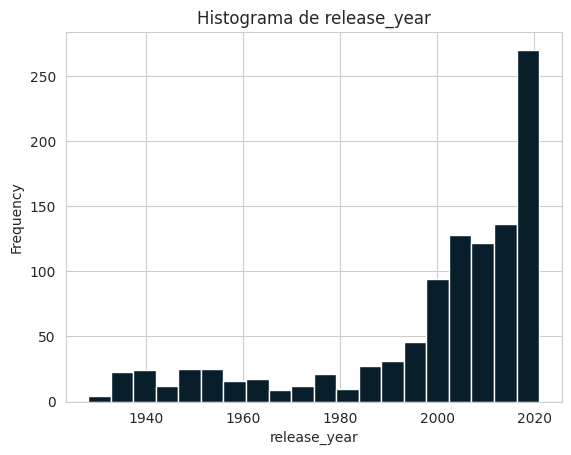

In [12]:
# Histograma release_year
if 'release_year' in df.columns and df['release_year'].notna().any():
    plt.figure()
    df['release_year'].dropna().astype(int).plot(kind='hist', bins=20, title='Histograma de release_year')
    plt.xlabel('release_year')
    plt.show()


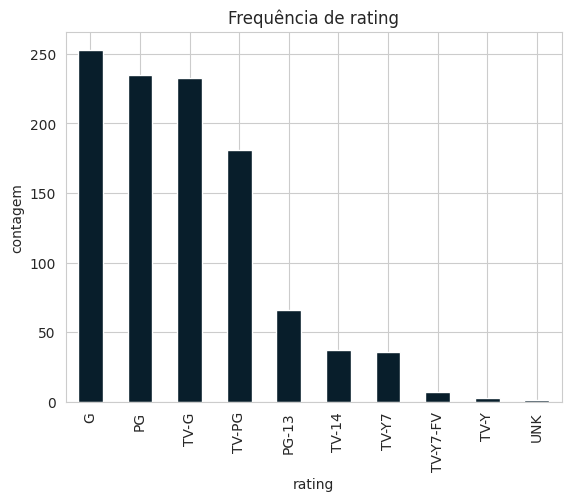

In [13]:
# Frequência rating
if 'rating' in df.columns:
    plt.figure()
    df['rating'].fillna('UNK').value_counts().sort_values(ascending=False).plot(kind='bar', title='Frequência de rating')
    plt.xlabel('rating')
    plt.ylabel('contagem')
    plt.show()

#### 3.1.1 Análise Descritiva Preliminar e ajustes de campos

In [14]:
#Resumo dos dados com verificacao de valores faltantes de forma tabular

resumo = pd.DataFrame({
    'Tipo de Dado': df.dtypes,
    'Valores Não Nulos': df.notnull().sum(),
    'Valores Nulos': df.isnull().sum()
})

print(resumo)

             Tipo de Dado  Valores Não Nulos  Valores Nulos
title              object               1052              0
release_year       object               1052              0
rating             object               1051              1


Considerando a seleção dos campos que serão utilizados no modelo, há somente 1 valor faltante no campo '*rating*'.

In [15]:
#Convertendo campo "release_year" para simplificar comparações anuais e futuro uso no modelo
df_convertido = df.copy()
df_convertido['release_year'] = pd.to_numeric(df_convertido['release_year'], errors='coerce').astype('Int64')

print("Tipo do campo release_yera:", df_convertido['release_year'].dtype)

df_convertido['release_year'].head()

Tipo do campo release_yera: Int64


,release_year
0,2016
1,1988
2,2011
3,2021
5,2021


O campo "release_year" foi convertido de tipo object para inteiro para viabilizar as estatísticas descritivas e simplificar as análises e a construção do modelo.

In [16]:
# Estatísticas Descritivas Numéricas Pós-conversão

#Identifica quais colunas do dataset são de tipo numérico e cria um novo repositório temporário
colunas_numericas = df_convertido.select_dtypes(include=['int64','float64','datetime']).columns

# Cria um dicionário para armazenar as estatísticas
estatisticas = {
    'Estatística': ['Mínimo', 'Máximo', 'Mediana', 'Moda', 'Média', 'Desvio-padrão', 'Valores Ausentes']
}

# Preenche o dicionário com os dados de cada coluna
for coluna in colunas_numericas:
    try:
        moda_valor = df_convertido[coluna].mode().values[0]
    except:
        moda_valor = None

    estatisticas[coluna] = [
        df_convertido[coluna].min(),
        df_convertido[coluna].max(),
        df_convertido[coluna].median() if pd.api.types.is_numeric_dtype(df_convertido[coluna]) else None,
        moda_valor,
        df_convertido[coluna].mean() if pd.api.types.is_numeric_dtype(df_convertido[coluna]) else None,
        df_convertido[coluna].std() if pd.api.types.is_numeric_dtype(df_convertido[coluna]) else None,
        df_convertido[coluna].isnull().sum()
    ]

# Converte o dicionário em DataFrame
df_estatisticas = pd.DataFrame(estatisticas)

# Exibe a tabela
df_estatisticas

,Estatística,release_year
0,Mínimo,1928.000000
1,Máximo,2021.000000
2,Mediana,2008.000000
3,Moda,2020.000000
4,Média,1999.230989
5,Desvio-padrão,23.858584
6,Valores Ausentes,0.000000


Foi criada uma cópia do dataset original *df* para o *df_convertido* e realizado um processo de conversão do campo ***release_year*** --> convertido para tipo *integer*



##### 3.1.2.2 Análise Descritiva em relação ao Ano de Lançamento

O ano de lançamento representa o ano em que o conteúdo foi disponibilizado para ser acessado seja nos cinemas, exibições particulares, mídias ou em plataformas de streaming.

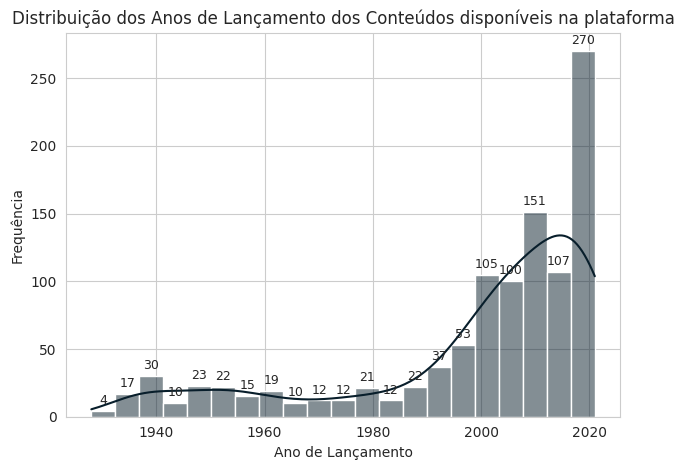

In [17]:
# Histograma do Ano de Lançamento (um dos atributos)

# Cria o histograma com curva de densidade
hist = sns.histplot(df_convertido['release_year'], kde=True)

# Título e rótulos dos eixos
plt.title('Distribuição dos Anos de Lançamento dos Conteúdos disponíveis na plataforma')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Frequência')

# Adiciona rótulos sobre as barras
for p in hist.patches:
    altura = p.get_height()
    if altura > 0:
        plt.annotate(f'{int(altura)}',
                     xy=(p.get_x() + p.get_width() / 2, altura),
                     xytext=(0, 5),
                     textcoords='offset points',
                     ha='center',
                     fontsize=9)

plt.tight_layout()
plt.show()

Observamos que a curva KDE é ascendente mostrando que a maior parte do conteúdo disponibilizado na plataforma de streaming Disney+ é mais recente, tendo esta curva se intensificado a partir dos anos 2000.


## 4. Definição do target, variáveis e divisão dos dados

Como se trata de um problema Não Supervisionado, a definição de *target* não se aplica.

Área de clusterização: `release_year` (numérico) e `rating` (categórico).

Split: **treino (train) 70% / validação (val) 15% / teste (test) 15%** para evitar sobreajuste de hiperparâmetros.

In [18]:
# Remove linhas sem as colunas essenciais para modelagem
df_model = df.dropna(subset=['release_year', 'rating']).copy()

train, temp = train_test_split(df_model, test_size=0.30, random_state=SEED, shuffle=True)
val, test  = train_test_split(temp,     test_size=0.50, random_state=SEED, shuffle=True)

log(f"Divisão -> treino: {train.shape}, validação: {val.shape}, teste: {test.shape}")

[2025-09-28 23:09:51] Divisão -> treino: (735, 3), validação: (158, 3), teste: (158, 3)



## 5. Tratamento de dados e **Pipeline** de pré-processamento


Pipeline com imputação, One-Hot para rating e padronização para release_year (sem vazamento).

In [20]:
pre = make_preprocess_pipeline(num_feat=('release_year',), cat_feat=('rating',))

t0 = time.time()
Xtr = pre.fit_transform(train)
t1 = time.time()

log(f"Pré-processamento (fit no train) em {t1 - t0:.3f}s")
log(f"Shape transformado (train): {Xtr.shape}")

[2025-09-28 23:10:01] Pré-processamento (fit no train) em 0.023s
[2025-09-28 23:10:01] Shape transformado (train): (735, 10)



## 6. Baseline e modelos candidatos



Conceitualmente, o baseline seria uma recomendação simples:
- título de mesma classificação
- associando ao ano de lançamento

Para o cenário de Clusterização, o baseline não se aplica diretamente, desta forma será utilizado um método simplificado:

**Baseline 0 (sanity):** K-Means k=3.

**Modelo alvo:** Clusterização Hierárquica (`ward`).

In [26]:
# Baseline K-Means (k=3) para referência
#from sklearn.exceptions import ConvergenceWarning
#import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Xtr_arr = to_array(Xtr)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=SEED)
t0 = time.time()
km_labels = kmeans.fit_predict(Xtr_arr)
t1 = time.time()

baseline_metrics = {
    'silhouette': silhouette_score(Xtr_arr, km_labels),
    'calinski_harabasz': calinski_harabasz_score(Xtr_arr, km_labels),
    'davies_bouldin': davies_bouldin_score(Xtr_arr, km_labels),
    'train_time_s': t1 - t0
}
log(f"Baseline KMeans k=3 -> {baseline_metrics}")
baseline_metrics

[2025-09-28 23:15:08] Baseline KMeans k=3 -> {'silhouette': np.float64(0.3312985793748151), 'calinski_harabasz': np.float64(458.1515017718956), 'davies_bouldin': np.float64(1.0652338540837871), 'train_time_s': 0.019397497177124023}


{'silhouette': np.float64(0.3312985793748151),
 'calinski_harabasz': np.float64(458.1515017718956),
 'davies_bouldin': np.float64(1.0652338540837871),
 'train_time_s': 0.019397497177124023}

K-Means é um algoritmo de aprendizado não supervisionado usado para agrupamento de dados (clustering) que tem como finalidade agrupar observações semelhantes em um número definido de grupos (clusters), sem usar rótulos previamente definidos.  Neste baseline utilizamos 3 clusters e o modelo candidato é a Clusterização Hierárquica (ward).


### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Ajuste do linkage no train, varredura de k e escolha por métricas internas.


In [27]:
cfg = ClusterConfig(linkage_method='ward', metric='euclidean', k_grid=(2, 9))

t0 = time.time()
Z = linkage(Xtr_arr, method=cfg.linkage_method, metric=cfg.metric)
t1 = time.time()
log(f"Linkage '{cfg.linkage_method}' ajustado em {t1 - t0:.3f}s")

ks = list(range(cfg.k_grid[0], cfg.k_grid[1]))
scores_train = evaluate_k_hierarchical(Z, Xtr_arr, ks)
display(scores_train)
best_k = int(scores_train.iloc[0]['k'])
log(f"k* sugerido (train): {best_k}")

[2025-09-28 23:15:11] Linkage 'ward' ajustado em 0.019s


,k,silhouette,calinski_harabasz,davies_bouldin
6,8,0.621090,590.986298,0.908346
4,6,0.596716,514.506736,0.894351
5,7,0.596520,568.829663,0.986056
3,5,0.533850,495.775221,0.909283
0,2,0.486356,586.209176,0.875396
2,4,0.439030,458.269195,1.004634
1,3,0.331102,452.013915,1.068566


[2025-09-28 23:15:11] k* sugerido (train): 8


##6.2 Visualização (scatter) - Baseline K-Means

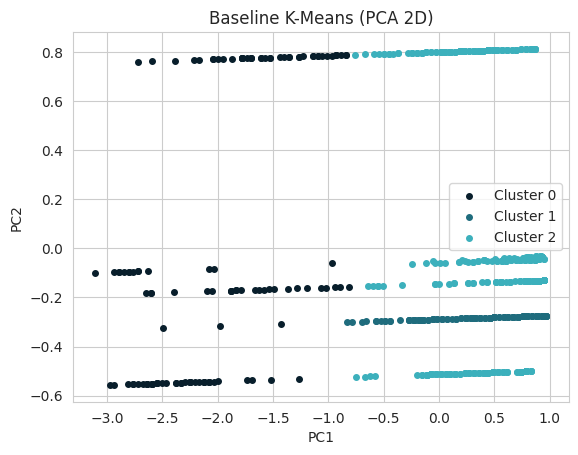

In [28]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca_km = PCA(n_components=2, random_state=SEED)
X_km_2d = pca_km.fit_transform(Xtr_arr)

plt.figure()
for cl in np.unique(km_labels):
    idx = (km_labels == cl)
    plt.scatter(X_km_2d[idx, 0], X_km_2d[idx, 1], label=f"Cluster {int(cl)}", s=16)
plt.title("Baseline K-Means (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## 7. Validação e Otimização de Hiperparâmetros

Usamos métricas internas para escolher k e verificamos coerência em val via centróides do train


In [29]:
labels_tr = fcluster(Z, t=best_k, criterion='maxclust')
val_proc = pre.transform(val)
val_labels, centroids = nearest_centroid_labels(val_proc, Xtr_arr, labels_tr)

val_metrics = {
    'silhouette': silhouette_score(to_array(val_proc), val_labels),
    'calinski_harabasz': calinski_harabasz_score(to_array(val_proc), val_labels),
    'davies_bouldin': davies_bouldin_score(to_array(val_proc), val_labels)
}
log(f"Métricas no VAL (rótulos por centróides do train): {val_metrics}")
val_metrics

[2025-09-28 23:16:08] Métricas no VAL (rótulos por centróides do train): {'silhouette': np.float64(0.6135250777186365), 'calinski_harabasz': np.float64(133.46865233317777), 'davies_bouldin': np.float64(0.9101563939477971)}


{'silhouette': np.float64(0.6135250777186365),
 'calinski_harabasz': np.float64(133.46865233317777),
 'davies_bouldin': np.float64(0.9101563939477971)}


## 8. Avaliação final, análise de erros e limitações

Refit em **train+val**, corte com `k*`, avaliação em **test** via centróides e inspeções por cluster.


In [30]:
# Refit no train+val
trval = pd.concat([train, val], axis=0).reset_index(drop=True)
Xtrval = pre.fit_transform(trval)
Z_final = linkage(to_array(Xtrval), method=cfg.linkage_method, metric=cfg.metric)
labels_trval = fcluster(Z_final, t=best_k, criterion='maxclust')

# Atribuição no teste via centróides
Xte = pre.transform(test)
test_labels, centroids_final = nearest_centroid_labels(Xte, Xtrval, labels_trval)

test_metrics = {
    'silhouette': silhouette_score(to_array(Xte), test_labels),
    'calinski_harabasz': calinski_harabasz_score(to_array(Xte), test_labels),
    'davies_bouldin': davies_bouldin_score(to_array(Xte), test_labels)
}
log(f"Métricas no TEST: {test_metrics}")
test_metrics


[2025-09-28 23:16:12] Métricas no TEST: {'silhouette': np.float64(0.6201003112760797), 'calinski_harabasz': np.float64(147.57002314255547), 'davies_bouldin': np.float64(0.9000888142456793)}


{'silhouette': np.float64(0.6201003112760797),
 'calinski_harabasz': np.float64(147.57002314255547),
 'davies_bouldin': np.float64(0.9000888142456793)}

## 8.1 Visualização Scatter - Clusterização Hierárquica

Redução para 2D via PCA *apenas para visualização* em *train + val* com cores diferentes dentro do esquema de cores Disney+ para facilitar a visualização.

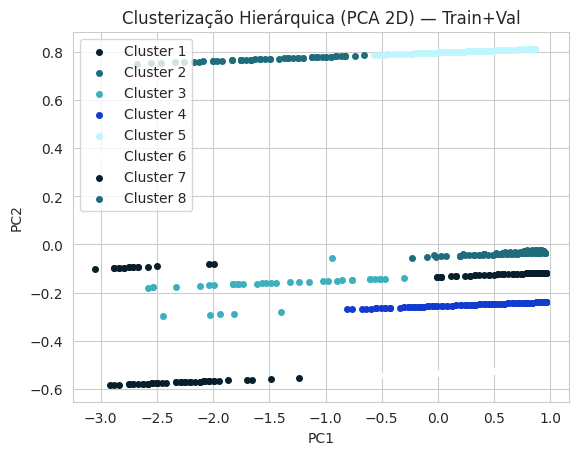

In [34]:
#from sklearn.decomposition import PCA
#import numpy as np
#import matplotlib.pyplot as plt

Xtrval_arr = (Xtrval.toarray() if hasattr(Xtrval, "toarray") else Xtrval)
pca_h = PCA(n_components=2, random_state=SEED)
X_h_2d = pca_h.fit_transform(Xtrval_arr)

plt.figure()
for cl in np.unique(labels_trval):
    idx = (labels_trval == cl)
    plt.scatter(X_h_2d[idx, 0], X_h_2d[idx, 1], label=f"Cluster {int(cl)}", s=16)
plt.title("Clusterização Hierárquica (PCA 2D) — Train+Val")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [32]:
# Sanity check: estatísticas por cluster (train+val)
trval_meta = trval.copy()
trval_meta['cluster'] = labels_trval

# Convert release_year to numeric, coercing errors
trval_meta['release_year'] = pd.to_numeric(trval_meta['release_year'], errors='coerce').astype('Int64')

display(trval_meta.groupby('cluster')['release_year'].agg(['count','min','median','mean','max']))
display(trval_meta.groupby(['cluster','rating']).size().to_frame('count').head(20))

,count,min,median,mean,max
cluster,,,,,
1,70,1928,1942.0,1944.342857,1972
2,59,1937,1967.0,1965.576271,1985
3,41,1937,1962.0,1963.853659,1991
4,179,1979,2007.0,2005.798883,2021
5,165,1987,2007.0,2006.50303,2021
6,143,1984,2010.0,2009.090909,2021
7,122,1998,2019.0,2016.090164,2021
8,114,1993,2016.0,2014.684211,2021


count
cluster rating         
1       TV-G         53
        TV-Y7        17
2       G            59
3       PG            5
        TV-PG        35
        TV-Y          1
4       PG          179
5       G           165
6       TV-G        143
7       TV-PG       122
8       PG-13        62
        TV-14        29
        TV-Y          2
        TV-Y7        15
        TV-Y7-FV      6


## 9. Engenharia de atributos (detalhe)



Para este modelo foram consideradas as features `release_year` e `rating`, por considerar que elas combinadas teriam mais relevância na recomendação de títulos semelhantes.

`release_year` foi padronizado
`rating` foi aplicada a técnica de `OneHotEncoding`

Extensões: *bucketing* de anos, ordinal/target encoding, interações

## 10. (Opcional) Deep Learning / Fine-tuning

**Não aplicável** ao escopo adotado neste projeto.

Futuro: Podem ser adicionados texto/descrição, para aplicação de embeddings e recomendação híbrida.


## 11. Boas práticas e rastreabilidade
- **Baseline** claro e justificativas para melhorias.  
- **Pipelines** (evitar vazamento).  
- **Decisões de projeto** documentadas (o que tentou e por quê).


Foi construído um pipeline com os tratamentos aplicados para que não houvesse vazamento de informações.

Adicionalmente a base pode evoluir considerando também as variáveis título e descrição através de DeepLearning para apurar ainda mais as recomendações de títulos.

Considerando o aprendizado não supervisionado e a técnica de Clusterização, foram selecionados os métodos:
- SEEDs fixas e versões documentadas
- Pipeline `sklearn` para previnir vazamento de dados
- Config externo (YAML/JSON)
- Logging de tempo/memória
- README com decisões


## 12. Conclusões e próximos passos



**Conclusões:** Foram obtidos clusters coerentes por `release_year` e `rating` permitindo recomendações básicas e explicáveis.

**Próximos passos:** adicionar gênero/duração/país, comparar HDBSCAN, recomendador híbrido e A/B testing.


## 13. Salvando artefatos (modelos e pipeline)

Salvamos o pipeline e os principais parâmetros do corte; também preparamos estruturas de recomendação.

In [334]:
# Estruturas de recomendação (train+val)
D, idx_by_cluster = build_recommender_struct(Xtrval, labels_trval)

# Persistência de artefatos
os.makedirs("artifacts", exist_ok=True)
joblib.dump(pre, "artifacts/preprocess_pipeline.joblib")
joblib.dump({
    'k': int(np.unique(labels_trval).size),
    'linkage_method': "ward",
    'metric': "euclidean",
    'centroids': centroids_final
}, "artifacts/clustering_artifacts.joblib")

log("Artefatos salvos em ./artifacts")

[2025-09-28 22:50:46] Artefatos salvos em ./artifacts


# 13.1 Exemplo de uso do Recomendador

Consulta **top-N** do **mesmo cluster**, ordenados por distância euclidiana no espaço transformado.

In [335]:

df_trval_meta = trval_meta[['title','release_year','rating','cluster']].reset_index(drop=True)

example_title = df_trval_meta['title'].iloc[0] if len(df_trval_meta)>0 else ""
log(f"Exemplo de título: {example_title}")

if example_title:
    recs = recommend(df_trval_meta, D, idx_by_cluster, example_title, topN=10)
    display(recs)
else:
    log("Não há títulos disponíveis para demonstrar a recomendação.")

[2025-09-28 22:51:54] Exemplo de título: Diary of a Wimpy Kid: Rodrick Rules


,title,release_year,rating,cluster
0,Mars Needs Moms,2011,PG,4
1,The Big Year,2011,PG,4
2,We Bought a Zoo,2011,PG,4
3,The Muppets,2011,PG,4
4,Prom,2011,PG,4
5,The Odd Life of Timothy Green,2012,PG,4
6,Frankenweenie,2012,PG,4
7,Wreck-It Ralph,2012,PG,4
8,Tangled,2010,PG,4
9,The Sorcerer's Apprentice,2010,PG,4
